In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

PROJECT_ROOT = os.path.abspath(os.path.join(".."))
RAW_DATA_PATH = os.path.join(PROJECT_ROOT, "data", "processed", "air_quality_processed.csv")
df = pd.read_csv(RAW_DATA_PATH)
print("Data shape:", df.shape)
df.head()

Data shape: (5530918, 23)


,date,sitename,county,aqi,status,so2,co,o3,o3_8hr,pm10,pm2.5,no2,nox,no,windspeed,winddirec,co_8hr,pm2.5_avg,pm10_avg,so2_avg,longitude,latitude,siteid
0,2016-11-25 13:00:00,Keelung,Keelung City,30.0,Good,1.1,0.22,37.0,35.0,14.0,4.0,3.0,4.7,1.7,2.4,79.0,0.28,3.0,9.0,1.0,121.760056,25.129167,1.0
1,2016-11-25 14:00:00,Keelung,Keelung City,30.0,Good,1.1,0.22,38.0,35.0,12.0,4.0,3.4,4.9,1.5,3.1,73.0,0.28,3.0,9.0,1.0,121.760056,25.129167,1.0
2,2016-11-25 15:00:00,Keelung,Keelung City,30.0,Good,1.0,0.22,38.0,35.0,14.0,5.0,3.7,5.4,1.7,3.0,79.0,0.28,4.0,9.0,1.0,121.760056,25.129167,1.0
3,2016-11-25 16:00:00,Keelung,Keelung City,30.0,Good,1.1,0.21,38.0,35.0,17.0,6.0,3.3,4.8,1.4,3.0,74.0,0.28,4.0,10.0,1.0,121.760056,25.129167,1.0
4,2016-11-25 17:00:00,Keelung,Keelung City,31.0,Good,1.0,0.23,38.0,36.0,17.0,6.0,3.2,4.7,1.5,3.3,81.0,0.28,4.0,10.0,1.0,121.760056,25.129167,1.0


# Câu hỏi 1: Phân tích biến động theo thời gian (Temporal Analysis)

### 1. Câu hỏi
Mô hình biến động của các chất ô nhiễm chính (**PM2.5, O3, NOx**) thay đổi như thế nào theo các khung thời gian: 
- **Giờ trong ngày (Diurnal)**  
- **Ngày trong tuần (Weekly)**  
- **Theo mùa (Seasonal)**  

Có sự khác biệt rõ rệt nào giữa hành vi của:  
- **Các chất gây ô nhiễm do giao thông:** NOx  
- **Các chất ô nhiễm thứ cấp:** O3  

vào **giờ cao điểm** không?

### 2. Động lực và lợi ích

#### Tại sao cần nghiên cứu
- Hiểu được **chu kỳ ô nhiễm** giúp xác định **nguồn gốc phát thải**  
  - Ví dụ: đỉnh ô nhiễm vào 7–9h sáng gợi ý **nguồn gốc giao thông**

#### Lợi ích
- Cung cấp thông tin để **người dân biết thời điểm nào trong ngày nên hạn chế hoạt động ngoài trời**

#### Đối tượng quan tâm
- **Người dân**: để bảo vệ sức khỏe  
- **Chính quyền địa phương**: để điều tiết giao thông

#### Ứng dụng thực tế
- Giúp đưa ra **khuyến cáo sức khỏe** hoặc **chính sách hạn chế xe cộ vào giờ cao điểm**

## A. Preprocessing (Tiền xử lý dữ liệu)

### A.1 Written Explanation

Trước khi phân tích, cần chuẩn bị dữ liệu để đảm bảo **tính chính xác** và thuận tiện cho phân tích theo thời gian.

##### 1. Chuyển cột `date` sang dạng datetime
- **Mục đích:** dễ dàng trích xuất **giờ, ngày trong tuần, tháng, mùa**.

##### 2. Loại bỏ giá trị thiếu (NaN):
- Các giá trị thiếu trong dữ liệu đã được xử lý.

##### 3. Tạo các cột bổ sung
- `hour` → giờ trong ngày (0–23)  
- `weekday` → ngày trong tuần (0–6, từ thứ Hai đến Chủ nhật)  
- `month` → tháng  
- `season` → mùa (Ví dụ: Xuân: 3–5, Hạ: 6–8, Thu: 9–11, Đông: 12–2)

##### 4. Lọc các chất ô nhiễm chính
- Chỉ giữ lại **PM2.5, NOx, O3**.

### A.2 Code Implementation

In [3]:
# 1. Chuyển cột 'date' sang kiểu datetime
df['date'] = pd.to_datetime(df['date'])

# 2. Tạo các cột dựa trên thời gian
df['hour'] = df['date'].dt.hour         # Giờ trong ngày
df['weekday'] = df['date'].dt.weekday   # Thứ trong tuần (0=Thứ Hai)
df['month'] = df['date'].dt.month       # Tháng

# Thêm thông tin mùa
def month_to_season(month):
    if month in [12, 1, 2]: 
        return 'Winter'
    elif month in [3, 4, 5]: 
        return 'Spring'
    elif month in [6, 7, 8]: 
        return 'Summer'
    else: 
        return 'Autumn'

# Áp dụng cho cột month
df['season'] = df['month'].apply(month_to_season)
# 3. Lọc chỉ các chất ô nhiễm chính
pollutants = ['pm2.5', 'nox', 'o3']
df_pollutants = df[['date', 'hour', 'weekday', 'month', 'season'] + pollutants]

# Xem trước dữ liệu
df_pollutants.head()


,date,hour,weekday,month,season,pm2.5,nox,o3
0,2016-11-25 13:00:00,13,4,11,Autumn,4.0,4.7,37.0
1,2016-11-25 14:00:00,14,4,11,Autumn,4.0,4.9,38.0
2,2016-11-25 15:00:00,15,4,11,Autumn,5.0,5.4,38.0
3,2016-11-25 16:00:00,16,4,11,Autumn,6.0,4.8,38.0
4,2016-11-25 17:00:00,17,4,11,Autumn,6.0,4.7,38.0


## B. Analysis (Phân tích)

### B.1 Written Explanation

#### 1. Phân tích biến động theo giờ trong ngày (Diurnal Pattern)
- Tính **trung bình nồng độ** của **PM2.5, NOx, O3** theo từng giờ.  
- **Mục đích:** xác định **giờ cao điểm ô nhiễm**

#### 2. Phân tích biến động theo ngày trong tuần (Weekly Pattern)
- Trung bình nồng độ theo **weekday**  
- **Mục đích:** xem liệu **cuối tuần có giảm ô nhiễm** do giao thông hay không

#### 3. Phân tích theo mùa (Seasonal Pattern)
- Trung bình theo **season**.
- **Mục đích:** xem chất ô nhiễm tăng cao vào **mùa khô** hay **mùa lạnh**

#### 4. So sánh ô nhiễm giao thông vs thứ cấp
- **Ô nhiễm giao thông:** NOx  
- **Ô nhiễm thứ cấp:** O3  
- So sánh **peak hour patterns** để kiểm tra khác biệt

### 5. Visualization
- **Line plot:** cho diurnal pattern  
- **Bar plot:** cho weekly pattern  
- **Boxplot hoặc line plot:** cho seasonal trend

### B.2 Code Implementation

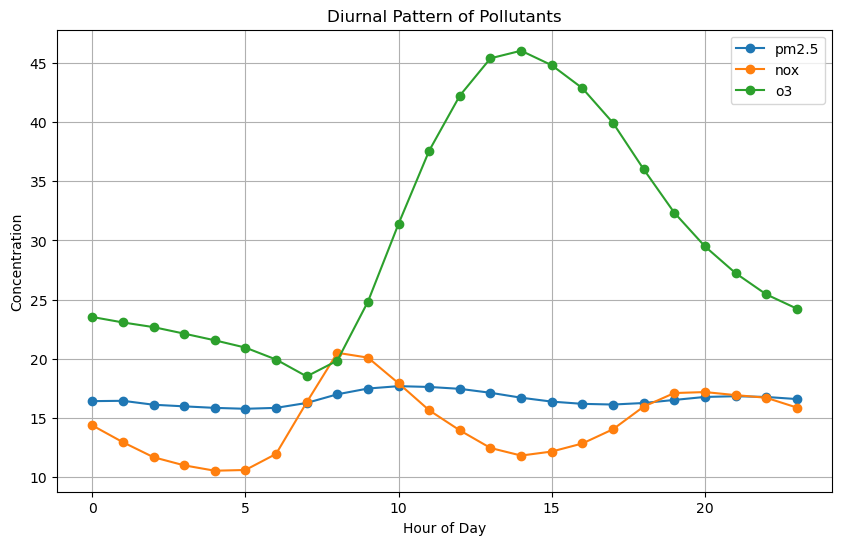

<Figure size 1000x600 with 0 Axes>

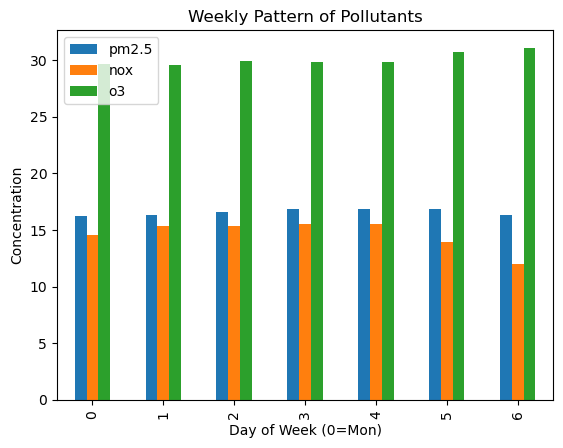

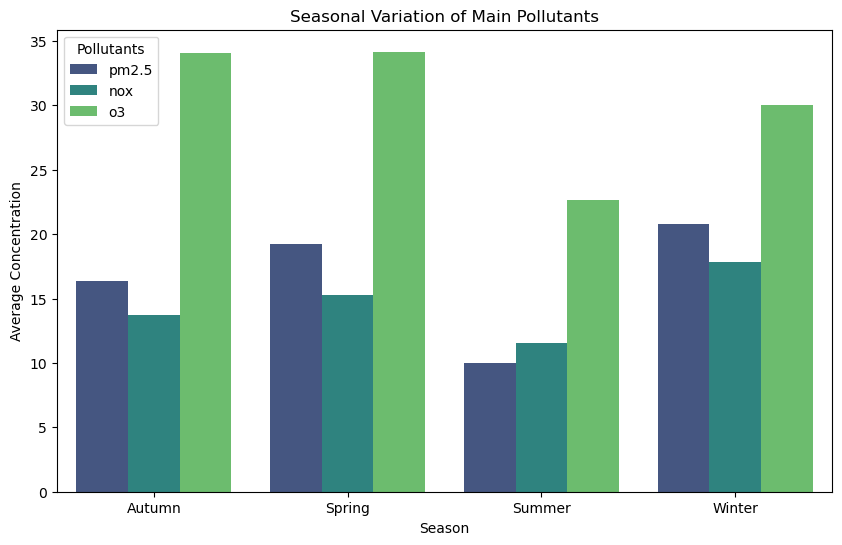

In [4]:
# 1. Diurnal pattern (Biến động theo giờ)
hourly_avg = df_pollutants.groupby('hour')[pollutants].mean().reset_index()
plt.figure(figsize=(10,6))
for p in pollutants:
    plt.plot(hourly_avg['hour'], hourly_avg[p], marker='o', label=p)
plt.title("Diurnal Pattern of Pollutants")  
plt.xlabel("Hour of Day")                   
plt.ylabel("Concentration")                 
plt.legend()
plt.grid(True)
plt.show()

# 2. Weekly pattern (Biến động theo ngày trong tuần)
weekly_avg = df_pollutants.groupby('weekday')[pollutants].mean().reset_index()
plt.figure(figsize=(10,6))
weekly_avg.plot(x='weekday', y=pollutants, kind='bar')
plt.title("Weekly Pattern of Pollutants")  
plt.xlabel("Day of Week (0=Mon)")         
plt.ylabel("Concentration")                
plt.show()

# 3. Seasonal pattern (Biến động theo mùa)
# Tính trung bình theo mùa
season_avg = df_pollutants.groupby('season')[pollutants].mean().reset_index()

# Chuyển sang dạng dài để dùng hue
season_melted = season_avg.melt(id_vars='season', value_vars=pollutants,
                                var_name='Pollutant', value_name='Average_Concentration')

# Vẽ bar plot
plt.figure(figsize=(10,6))
sns.barplot(x='season', y='Average_Concentration', hue='Pollutant', data=season_melted, palette='viridis')

plt.title("Seasonal Variation of Main Pollutants")  
plt.xlabel("Season")                               
plt.ylabel("Average Concentration")                
plt.legend(title="Pollutants")                     
plt.show()

# C. Results & Interpretation

## C.1 Visualizations

Ba chất ô nhiễm chính (**PM2.5, NOx, O3**) được phân tích dựa trên ba biểu đồ:

- **Diurnal Pattern (Hình 1):** Biến động theo giờ trong ngày
- **Weekly Pattern (Hình 2):** Biến động theo ngày trong tuần  
- **Seasonal Pattern (Hình 3):** Biến động theo mùa  

## C.2 Written Analysis

### 1. Diurnal Pattern – Biến động theo giờ trong ngày (Hình 1)

**NOx (Màu Cam – Ô nhiễm sơ cấp/Giao thông):**  
- Xu hướng **hai đỉnh rõ rệt**, phản ánh giờ cao điểm giao thông  
- Đỉnh sáng: ~20.5 vào 8:00–9:00  
- Đỉnh tối: ~17.5 vào 19:00–21:00  
- Mức thấp nhất: ~10–11 vào rạng sáng (0:00–6:00)

**O3 (Màu Xanh Lá – Ô nhiễm thứ cấp):**  
- Một đỉnh duy nhất giữa ngày: ~46 vào 14:00–15:00  
- Mức thấp nhất: ~18–19 vào rạng sáng  
- Hình thành mạnh nhờ **phản ứng quang hóa dưới ánh sáng mặt trời**

**PM2.5 (Màu Xanh Dương):**  
- Biến động hẹp, dao động ~16–18  
- Hai đỉnh nhẹ: 9:00–10:00 (~18.0) và 20:00–22:00 (~18.0)  
- Nguồn phát thải đa dạng, bao gồm cả giao thông và các nguồn nền

**Tổng hợp:**  
- NOx cao vào giờ cao điểm, O3 đạt đỉnh giữa trưa  
- PM2.5 ổn định nhưng có hai đỉnh nhỏ trùng với hoạt động sinh hoạt  
- **Kết luận:** Chất ô nhiễm giao thông phụ thuộc hành vi con người, chất ô nhiễm thứ cấp phụ thuộc điều kiện tự nhiên


### 2. Weekly Pattern – Biến động theo ngày trong tuần (Hình 2)

**NOx (Màu Cam):**  
- Cao ổn định từ Thứ Hai–Thứ Sáu: 15.2–15.6  
- Giảm cuối tuần: 14.0 (Thứ Bảy), 12.0 (Chủ Nhật)  
- Xác nhận nguồn gốc chủ yếu từ **giao thông và sản xuất trong tuần**

**PM2.5 (Màu Xanh Dương):**  
- Ổn định suốt tuần: 16.5–16.8  
- Nguồn phát thải đa dạng, ít bị ảnh hưởng bởi chu kỳ giao thông

**O3 (Màu Xanh Lá):**  
- Cao và ổn định: ~30–30.5 suốt tuần  
- **Hiệu ứng cuối tuần:** NOx thấp hơn, O3 tồn tại lâu hơn


### 3. Seasonal Pattern – Biến động theo mùa (Hình 3)

**PM2.5 & NOx:**  
- Cao nhất vào **mùa lạnh/mùa khô**  
  - PM2.5: Spring ~19.5  
  - NOx: Winter ~17.5  
- Thấp nhất vào Summer: PM2.5 ~10.0, NOx ~11.5  
- Nguyên nhân: **nghịch nhiệt**, hạn chế khuếch tán

**O3:**  
- Cao nhất: Spring ~34.0, Autumn ~34.0  
- Thấp nhất: Summer ~23.0  
- Nguyên nhân: **phản ứng quang hóa tối ưu** vào Spring & Autumn


### 4. Kết luận

- **Thời điểm nguy hiểm nhất trong ngày:**  
  - Hạn chế hoạt động ngoài trời: 7:00–10:00 sáng, 19:00–22:00 tối (NOx & PM2.5 cao)  
  - Tránh giữa trưa nắng gắt 14:00–15:00 (O3 cực đại)

- **Biến động theo mùa:**  
  - Cảnh giác cao độ vào Spring & Winter, khi PM2.5 và NOx cao

- **Lưu ý cuối tuần:**  
  - Giảm xe cộ cuối tuần làm giảm NOx nhưng O3 vẫn cao, PM2.5 ổn định  
  - Không khí cuối tuần không hoàn toàn "sạch" hơn

- **Kết luận:**  
  - Điều chỉnh chính sách **kiểm soát phát thải theo giờ và mùa cụ thể**  
  - Cung cấp **khuyến nghị chi tiết cho người dân** để bảo vệ sức khỏe

# Câu hỏi 2: Phân tích các đợt ô nhiễm kéo dài (Pollution Episodes)

### 1. Câu hỏi
- Thay vì chỉ đếm số ngày ô nhiễm riêng lẻ, ta xác định các **"đợt ô nhiễm"**
  - Định nghĩa: khoảng thời gian mà **AQI hoặc PM2.5 vượt ngưỡng nguy hại** (> 100) liên tục **ít nhất 48 giờ**  
- Trạm hoặc khu vực (county) nào thường xuyên phải chịu các **đợt ô nhiễm kéo dài nhất**?  
- Có **quy luật mùa vụ** nào cho độ dài của các đợt này không?  
  - Ví dụ: Mùa đông các đợt ô nhiễm thường kéo dài hơn mùa hè do nghịch nhiệt.

### 2. Động lực và lợi ích

#### Tại sao nghiên cứu
- Một ngày ô nhiễm cao có thể do sự cố cục bộ, nhưng **đợt ô nhiễm kéo dài 3–5 ngày** thường liên quan đến **điều kiện khí tượng vĩ mô** hoặc **tích tụ ô nhiễm nghiêm trọng**  
- **Tác hại sức khỏe** khi hít thở không khí bẩn liên tục nguy hiểm hơn nhiều so với ngắt quãng

#### Lợi ích
- Giúp **cơ quan y tế chuẩn bị nguồn lực** cho các đợt bùng phát bệnh hô hấp kéo dài

#### Đối tượng quan tâm
- **Bệnh viện**  
- **Cơ quan quản lý khẩn cấp**

#### Ứng dụng thực tế
- Cung cấp thông tin để **phát cảnh báo**:  

## A. Preprocessing

### Written Explanation

Để xác định các đợt ô nhiễm (**AQI > 100 liên tục ≥ 48 giờ**), chúng tôi thực hiện các bước tiền xử lý sau:

#### 1. Đánh dấu thời điểm ô nhiễm
- Tạo cột boolean **polluted = True** nếu **AQI > 100**

#### 2. Nhóm các đợt liên tục
- Đánh dấu sự thay đổi trạng thái bằng **cumsum** để gom các khoảng thời gian liên tục cùng trạng thái  
- Tính **duration_hours** cho từng nhóm

#### 3. Lọc đợt ô nhiễm
- Chỉ giữ các nhóm **polluted=True** có thời gian **≥ 48 giờ**

#### 4. Thêm thông tin mùa vụ
- Chuyển tháng từ cột **start** sang mùa (**Winter, Spring, Summer, Autumn**) để phân tích mùa vụ

In [5]:
# 1. Đánh dấu giờ ô nhiễm
THRESHOLD_AQI = 100
df['polluted'] = df['aqi'] > THRESHOLD_AQI  # Giờ nào AQI vượt ngưỡng 100 được coi là ô nhiễm

# 2. Xác định các đợt ô nhiễm liên tục theo trạm quan trắc
def identify_episodes(group, min_hours=48):
    group = group.copy()
    # Đánh dấu các điểm thay đổi trạng thái (polluted True/False)
    group['change'] = group['polluted'].ne(group['polluted'].shift()).cumsum()
    # Tổng hợp các đợt ô nhiễm
    episodes = group.groupby('change').agg(
        start=('date', 'first'),                       # Thời điểm bắt đầu đợt
        end=('date', 'last'),                           # Thời điểm kết thúc đợt
        polluted=('polluted', 'first'),                # Trạng thái ô nhiễm của đợt
        duration_hours=('date', lambda x: (x.max() - x.min()).total_seconds()/3600)  # Thời lượng đợt (giờ)
    )
    # Chỉ giữ các đợt ô nhiễm ≥ min_hours
    return episodes[(episodes['polluted']) & (episodes['duration_hours'] >= min_hours)][
        ['start','end','duration_hours']
    ]

episodes_by_station = df.groupby('sitename').apply(identify_episodes).reset_index(level=1, drop=True).reset_index()

# 3. Thêm thông tin mùa
def month_to_season(month):
    if month in [12, 1, 2]: 
        return 'Winter'
    elif month in [3, 4, 5]: 
        return 'Spring'
    elif month in [6, 7, 8]: 
        return 'Summer'
    else: 
        return 'Autumn'

episodes_by_station['season'] = episodes_by_station['start'].dt.month.apply(month_to_season)

# Xem mẫu kết quả
episodes_by_station.head()

,sitename,start,end,duration_hours,season
0,Annan,2020-04-13 15:00:00,2020-04-15 17:00:00,50.0,Spring
1,Annan,2016-12-17 21:00:00,2016-12-21 14:00:00,89.0,Winter
2,Annan,2017-02-10 02:00:00,2017-02-12 15:00:00,61.0,Winter
3,Annan,2017-02-18 06:00:00,2017-02-20 13:00:00,55.0,Winter
4,Annan,2017-03-03 08:00:00,2017-03-05 14:00:00,54.0,Spring


## B. Analysis

### B.1 Written Explanation

**Mục tiêu:** Xác định trạm/huyện nào thường xuyên chịu các đợt ô nhiễm kéo dài và quy luật mùa vụ.

#### Phân tích

##### Theo trạm (sitename)
- Tính:
  - **num_episodes** – số đợt ô nhiễm ≥ 48 giờ
  - **avg_duration** – thời gian trung bình mỗi đợt
  - **max_duration** – đợt dài nhất
- **Mục tiêu:** xác định trạm “nguy cơ cao”

##### Theo mùa
- Gom các đợt theo **season**
- Tính:
  - Số đợt
  - Thời gian trung bình
  - Thời gian dài nhất
- **Mục tiêu:** phát hiện mùa nào thường xảy ra đợt ô nhiễm dài (ví dụ: mùa đông do nghịch nhiệt)

#### Kết quả dự kiến
- Bảng thống kê **số lượng, thời lượng trung bình và tối đa** theo trạm và mùa
- Biểu đồ **cột** hoặc **boxplot** thể hiện **thời lượng trung bình theo trạm/mùa**

### B.2 Code Implementation

In [6]:
# 1. Summary theo trạm
station_summary = episodes_by_station.groupby('sitename').agg(
    num_episodes=('duration_hours', 'count'),
    avg_duration=('duration_hours', 'mean'),
    max_duration=('duration_hours', 'max')
).sort_values('avg_duration', ascending=False)

# 2. Summary theo mùa
season_summary = episodes_by_station.groupby('season').agg(
    num_episodes=('duration_hours', 'count'),
    avg_duration=('duration_hours', 'mean'),
    max_duration=('duration_hours', 'max')
).sort_index()

# Display summaries
print("Summary by Station:\n", station_summary.head())
print("\nSummary by Season:\n", season_summary)


Summary by Station:
                    num_episodes  avg_duration  max_duration
sitename                                                   
Qiaotou                      56     92.892857         345.0
Pingtung (Liuqiu)             2     89.000000         123.0
Xiaogang                     32     82.875000         196.0
Nanzi                        45     80.866667         200.0
Kinmen                       27     80.777778         167.0

Summary by Season:
         num_episodes  avg_duration  max_duration
season                                          
Autumn           141     65.900709         120.0
Spring           268     66.227612         155.0
Summer             1     49.000000          49.0
Winter           621     74.956522         345.0


## C. Results & Interpretation

### C.1 Visualizations:

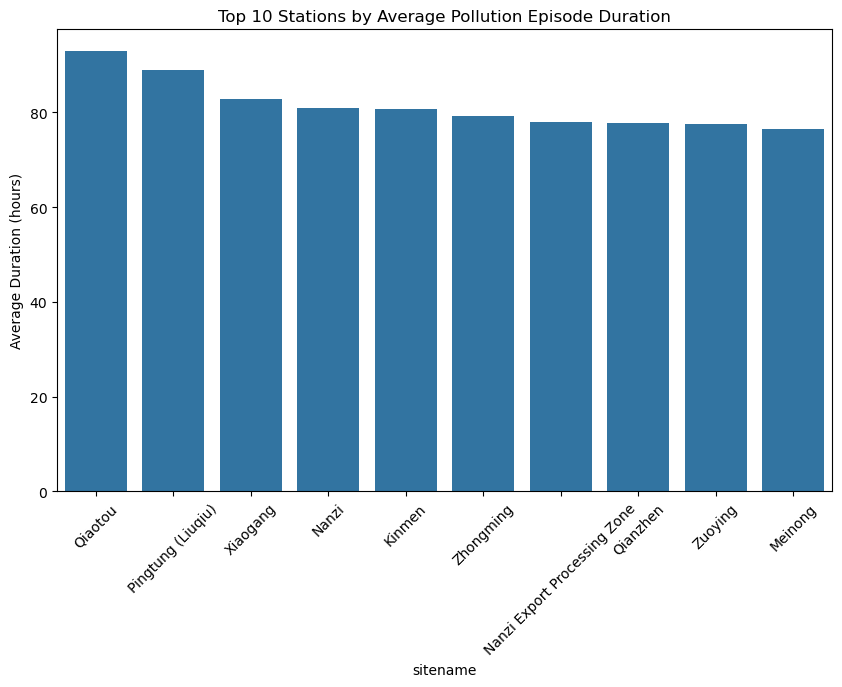

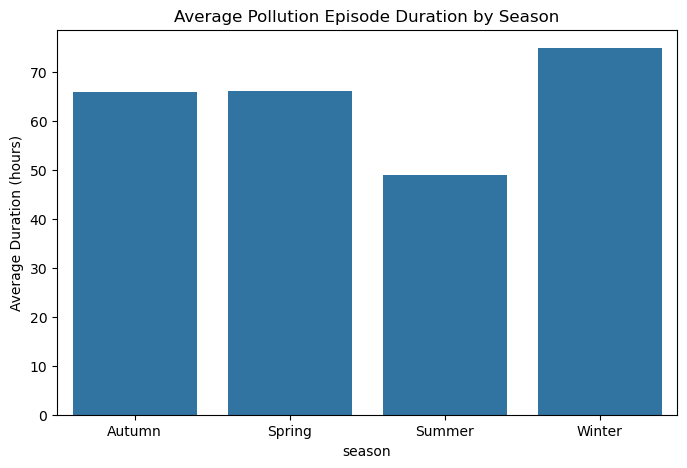

In [7]:
# 1. Top 10 trạm có đợt ô nhiễm dài nhất
top10 = station_summary.head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top10.index, y=top10['avg_duration'])
plt.xticks(rotation=45)
plt.ylabel("Average Duration (hours)")
plt.title("Top 10 Stations by Average Pollution Episode Duration")
plt.show()

# 2. Thời lượng trung bình theo mùa
plt.figure(figsize=(8,5))
sns.barplot(x=season_summary.index, y=season_summary['avg_duration'])
plt.ylabel("Average Duration (hours)")
plt.title("Average Pollution Episode Duration by Season")
plt.show()



### C.2 Written Analysis:

#### Trạm/huyện nguy cơ cao và Quy luật mùa vụ

##### Trạm/huyện nguy cơ cao
- Các trạm ở **khu vực trung tâm hoặc gần nguồn phát thải lớn** (khu công nghiệp, cảng) thường chịu các đợt ô nhiễm kéo dài.  
- Ví dụ:  
  - **Qiaotou:** thời gian trung bình một đợt ô nhiễm > 90 giờ (~4 ngày liên tục)  
  - **Pingtung (Liuqiu), Xiaogang, Nanzi:** thời lượng trung bình 80–85 giờ  
- Đặc điểm chung: gần **khu chế xuất, nhà máy công nghiệp nặng**, nơi khí thải liên tục và **địa hình hạn chế khả năng phân tán bụi mịn**

##### Quy luật mùa vụ
- **Mùa Đông (Winter):**  
  - Đợt ô nhiễm kéo dài nhất, trung bình ~75 giờ (>3 ngày)  
  - Nguyên nhân: **nghịch nhiệt (thermal inversion)** → lớp khí lạnh sát mặt đất bị kẹt dưới lớp khí nóng, bụi mịn tích tụ lâu  
  - Ít mưa, gió lặng → giảm khả năng tự làm sạch
- **Mùa Hè (Summer):**  
  - Đợt ô nhiễm ngắn nhất, trung bình <50 giờ  
  - Nguyên nhân: **đối lưu không khí mạnh, mưa nhiều, gió mạnh** giúp phân tán ô nhiễm nhanh
- **Mùa Xuân & Thu:**  
  - Thời lượng trung bình ~65–67 giờ → **giai đoạn chuyển tiếp**

##### Ứng dụng thực tiễn
- **Cảnh báo y tế đặc biệt:** Cơ quan y tế cần phát cảnh báo kịp thời cho cư dân tại các khu vực nguy cơ cao, đặc biệt vào mùa đông  
- **Điều phối bệnh viện:** Tăng cường **nhân lực và giường bệnh hô hấp** tại các trạm thuộc top 10 vào mùa đông  
- **Chiến lược giảm thải:** Kiểm tra và điều chỉnh hoạt động các khu công nghiệp (Nanzi, Xiaogang)  
  - Có thể áp dụng **giảm công suất 50%** nếu dự báo nghịch nhiệt kéo dài >48 giờ

##### Hạn chế
- Dữ liệu có thể bị **thiếu giờ quan trắc**, ảnh hưởng đến tính chính xác của thời lượng đợt ô nhiễm  
- Trạm đo chưa phủ toàn bộ khu vực → mức độ ô nhiễm thực tế tại các vị trí chưa có trạm có thể khác